In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Define data paths

In [2]:
data_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Data/2_eye/New')
game_dir = os.path.join(data_dir, 'game')
eyet_dir = os.path.join(data_dir, 'eyet')
mous_dir = os.path.join(data_dir, 'mous')
output_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Analysis/2_eye/histograms')
game_files = [os.path.join(game_dir, g) for g in os.listdir(game_dir) if g[-3:]=='csv']
eyet_files = [os.path.join(eyet_dir, e) for e in os.listdir(eyet_dir) if e[-3:]=='csv']
mous_files = [os.path.join(mous_dir, m) for m in os.listdir(mous_dir) if m[-3:]=='csv']

# Load data

Notes:

1. Computer logs timestamps as "0", so when computer makes last move, we lose time index
2. Solution: load raw game data with "ready" entries, as these have timestamp for game beginning.
3. Now requires further processing :(

In [3]:
subject_initial_map = [g[-6:-4] for g in game_files]
subject_initial_map = dict(zip(subject_initial_map, np.arange(len(subject_initial_map))))

top = 192
bottom = 506
left = 177
right = 889
width = right - left
height = bottom - top

def expand_mouse_mt(row):
    endtime = int(row['ts'])
    starttime = endtime - int(row['rt'])
    if type(row['mt'])==str:
        return str(starttime) + ',' + row['mt'] + ',' + str(endtime)
    
def expand_mouse_mx(row):
    endtime = int(row['ts'])
    starttime = endtime - int(row['rt'])
    if type(row['mx'])==str:
        locs = row['mx'].split(';')
        endloc = locs[-1]
        startloc = locs[0]
        return startloc + ';' + row['mx'] + ';' + endloc
    
def fix_game_boards(row):
    bp, wp = row[['bp', 'wp']]
    if row['color']==0:
        p = list(bp)
        p[int(row['zet'])] = '0'
    else:
        p = list(wp)
        p[int(row['zet'])] = '0'

    return ''.join(p)

In [4]:
def load_game_file(gf):
    mfnames = ['idx', 'id', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts', 'mt', 'mx']

    D = pd.read_csv(gf, names=mfnames)
    D = D.loc[~((D['status']=='ready')&(D['rt']==0))]
    D.loc[D['status']=='ready', 'rt'] = 0
    D['subject'] = gf[-6:-4]
    D['human'] = D['subject'].map(subject_initial_map)
    D['tstemp'] = (D['ts'] - D['rt']).shift(-1)
    c = (D['rt']==0) | (D['status']=='ready')
    D.loc[c, 'ts'] = D.loc[c, 'tstemp']
    D['mx'] = D.apply(expand_mouse_mx, axis=1)
    D['mt'] = D.apply(expand_mouse_mt, axis=1)
    D['is human'] = 1
    D.loc[D['status'].isin(['playing', 'win', 'draw']) & (D['rt']==0), 'is human'] = 0
    c = D['status'].isin(['win', 'draw'])
    idx = D.loc[c].index
    if D.loc[idx[-1], 'rt'] != 0:
        D.loc[idx[-1], 'gi'] = D.loc[idx[-1], 'gi'] - 1
    D.loc[D['color']==0, 'bp'] = D.loc[D['color']==0].apply(fix_game_boards, axis=1)
    D.loc[D['color']==1, 'wp'] = D.loc[D['color']==1].apply(fix_game_boards, axis=1)
    return D.set_index('ts')

def load_mous_file(mf):
    mfnames = ['idx', 'id', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts', 'mt', 'mx']
    D = pd.read_csv(mf, names=mfnames)
    valid = pd.notnull(D['mt'])
    D['mx'] = D.apply(expand_mouse_mx, axis=1)
    D['mt'] = D.apply(expand_mouse_mt, axis=1)
    D = D[['mt', 'mx']]
    
    m = (D.loc[valid, 'mt'] + ',').sum().split(',')[:-1]
    x = [tuple(xy.split(',')) for xy in (D.loc[valid, 'mx'] + ';').sum().split(';')][:-1]
    
    M = pd.DataFrame(index=m, data=x, columns=['x', 'y'])
    M['subject'] = mf[-6:-4]
    M['human'] = M['subject'].map(subject_initial_map)
    M.index = M.index.astype(int)
    return M

def load_eyet_file(ef):
    D = pd.read_csv(ef)
    D['subject'] = ef[-6:-4]
    D['human'] = D['subject'].map(subject_initial_map)
    D[['start', 'end']] = (D[['start', 'end']]*1000).astype(int)
    return D[['start', 'end', 'transx', 'transy', 'human']].set_index('start')

def mouse_x_to_tile(x):
    return 9*(x - left) / width

def mouse_y_to_tile(y):
    return 4*(y - top) / height

def make_tidy(subject_index):
    print(subject_index)
    e, m, g = [l[subject_index] for l in [e_list, m_list, g_list]]
    start_time = int(e.index[0])
    end_time = int(e.loc[e.index.values[-1], 'end'])
    m = m.loc[(m.index >= start_time) & (m.index <= end_time)]
    D = pd.DataFrame(index=np.arange(start_time, end_time, 1))
    D.loc[e.index, 'eyex'] = e['transx'].astype(float)
    D.loc[e.index, 'eyey'] = e['transy'].astype(float)
    D.loc[e.index, 'eyeflag'] = 1
    
    D.loc[m.index, 'moux'] = m['x'].astype(float).map(mouse_x_to_tile)
    D.loc[m.index, 'mouy'] = m['y'].astype(float).map(mouse_y_to_tile)
    D.loc[m.index, 'mouflag'] = 1
    
    _sl = g.loc[g.index > start_time, :]
    
    D.loc[_sl.index, 'turn'] = 100*_sl['gi'] + _sl['mi']
    D.loc[_sl.index, 'task'] = _sl['status']
    
    D = D.dropna(how='all')
    fillcols = ['eyex', 'eyey', 'moux', 'mouy', 'turn', 'task']
    D[fillcols] = D[fillcols].fillna(method='ffill')
    
    D['ts'] = D.index
    D.loc[D['eyeflag']==1, 'eyedur'] = D.loc[D['eyeflag']==1, 'ts'].diff(periods=1)
    D.loc[D['mouflag']==1, 'moudur'] = D.loc[D['mouflag']==1, 'ts'].diff(periods=1)
                               
    D['eyetile'] = D['eyex'] + 9*D['eyey']
    D['moutile'] = D['moux'] + 9*D['mouy']
    D.loc[D['eyeflag']==1, 'eyetile'] =  D.loc[D['eyeflag']==1, 'eyetile'].astype(int)
    D.loc[D['mouflag']==1, 'moutile'] =  D.loc[D['mouflag']==1, 'moutile'].astype(int)

    return D

In [5]:
e_list = [load_eyet_file(e) for e in eyet_files]
m_list = [load_mous_file(m) for m in mous_files]
g_list = [load_game_file(g) for g in mous_files]

t = [make_tidy(i) for i in range(len(e_list))]

mpivs = []
epivs = []
for i in range(len(m_list)):
    
    # mouse histograms
    m = m_list[i]
    g = g_list[i]
    g['turn'] = 100*g['gi'] + g['mi']
    gp = g.loc[g['status'].isin(['playing', 'draw', 'win'])]
    m['turn'] = np.nan
    m['turnstart'] = np.nan
    m['turnend'] = np.nan
    m['ts'] = m.index
    m['xtile'] = np.nan
    m['ytile'] = np.nan
    m['tile'] = np.nan
    m['dur'] = np.nan
    m['is human'] = np.nan
    m = m.drop_duplicates(subset='ts')
    m.loc[gp.index, 'turn'] = gp['turn']
    m.loc[gp.index, 'turnstart'] = gp.index - gp['rt']
    m.loc[gp.index, 'turnend'] = gp.index
    m.loc[gp.index, 'is human'] = gp['is human']

    m = m.sort_index()
    m[['turn', 'turnstart', 'turnend', 'is human']] = m[['turn', 'turnstart', 'turnend', 'is human']].fillna(method='bfill')

    m['dur'] = m.index
    m['dur'] = m['dur'].diff(periods=1)
    m = m.loc[(m.index>m['turnstart'])&(m.index<=m['turnend'])]

    m['xtile'] = m['x'].astype(float).map(mouse_x_to_tile)
    m['ytile'] = m['y'].astype(float).map(mouse_y_to_tile)
    m['tile'] = (m['xtile'] + 9*m['ytile']).astype(int)

    m_list[i] = m
    
    mpvt = m.loc[m['is human']==1].pivot_table(index='turn', columns='tile', values='dur', aggfunc=np.sum)
    mpvt['rt'] = mpvt.sum(axis=1)
    mpvt[999] = mpvt[[i for i in mpvt.columns if (i not in list(range(36)) and type(i)==int)]].sum(axis=1)

    gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
    mpvt.loc[gt.index, 'true rt'] = gt['rt']
    mpvt = mpvt.fillna(value=0)
    print(np.abs(mpvt['rt'] - mpvt['true rt']).sum())
    for c in ['bp', 'wp', 'zet']:
        mpvt.loc[gt.index, c] = gt[c]
        
    for c in range(36):
        if c not in mpvt.columns:
            mpvt[c] = 0
    
    mpivs.append(mpvt)
    
    # eye histograms
    
        # note: eye hist requires including ready markers to distinguish correctly, due to latency etc
        # (mousetracking does not record until after ready stops)
        
    e = e_list[i]
    g = g_list[i]
    g['turn'] = 100*g['gi'] + g['mi']
    gp = g.loc[g['status'].isin(['ready', 'playing', 'draw', 'win'])]
    gp['turnstart'] = gp.index - gp['rt']
    gp['turnend'] = gp.index

    e['turnstart'] = np.nan
    e['turnend'] = np.nan
    e['ts'] = e.index
    e['tile'] = np.nan
    e['dur'] = np.nan
    e = e.drop_duplicates(subset='ts')
    e = e.append(gp[['turn', 'is human', 'turnstart', 'turnend']])
    e = e.sort_index()
    e[['turn', 'turnstart', 'turnend', 'is human']] = e[['turn', 'turnstart', 'turnend', 'is human']].fillna(method='bfill')

    e['tile'] = e['transx'] + 9*e['transy']
    e['tile'] = e['tile'].fillna(method='ffill') #.astype(int)
    e.loc[pd.notnull(e['tile']), 'tile'] = e.loc[pd.notnull(e['tile']), 'tile'].astype(int)
    e['dur'] = e.index
    e['dur'] = e['dur'].diff(periods=1)
    
    c = (e.index>=e['turnstart'])&(e.index<=e['turnend'])
    e = e.loc[c]
    
    e_list[i] = e

    epvt = e.loc[e['is human']==1].pivot_table(index='turn', columns='tile', values='dur', aggfunc=np.sum)
    epvt.columns = epvt.columns.astype(int)
    
    epvt['rt'] = epvt.sum(axis=1)
    epvt[999] = epvt[[i for i in epvt.columns if (i not in list(range(36)) and type(i)==int)]].sum(axis=1)
    gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
    epvt.loc[gt.index, 'true rt'] = gt['rt']
    for c in ['bp', 'wp', 'zet']:
        epvt.loc[gt.index, c] = gt[c]
        
    epvt = epvt.loc[(epvt.index%100)!=0].fillna(value=0)
    
    for c in range(36):
        if c not in epvt.columns:
            epvt[c] = 0
    print(np.abs(epvt['rt'] - epvt['true rt']).sum())

    epivs.append(epvt)

0
1
2
3
4
5
6
7
8
9


/Users/gianni/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0
0.0


/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Export

In [19]:
for i in range(len(mpivs)):
    mp = mpivs[i]
    ep = epivs[i]
    
    mp[list(range(36)) + [999, 'bp', 'wp', 'zet']].to_csv(os.path.join(output_dir, 'mouse {}.csv'.format(i)))
    ep[list(range(36)) + [999, 'bp', 'wp', 'zet']].to_csv(os.path.join(output_dir, 'eye {}.csv'.format(i)))

# Histograms

In [51]:
mp = mpivs[0][[i for i in mpivs[0].columns if i not in list(range(36))]]
mpn = mp / mp.sum(axis=0)
mpn.head()

tile,36,37,38,39,40,41,rt,true rt
turn,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.004620,0.004620
3.0,0.000000,0.001174,0.000000,0.313777,0.0,0.0,0.011609,0.011609
5.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.006943,0.006943
7.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.002936,0.002936
102.0,0.000329,0.001027,0.000621,0.051964,0.0,0.0,0.003970,0.003970


In [46]:
ep = epivs[0][[i for i in range(36)]]
epn = ep / ep.sum(axis=0)
epn.head()

tile,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
turn,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.206619,0.054391,0.026586,0.009012,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.061862,0.097706,0.000000,0.000000,0.000000,...,0.001790,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.009237,0.020294,0.0,0.023117,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011632,0.008353,0.003560,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
102.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.219872,0.012044,0.003275,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [49]:
def KLD(A, B):
    return (A*np.log(A/B)), axis=1)

KLD(mpn.values, epn.values)

/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


array([[ nan,  inf,  inf, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  inf,  inf],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  inf,  inf,  inf],
       [ nan,  nan,  inf, ...,  inf,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

# Statistics

0 x 0.624531268239 0.0
0 y 0.471510960253 0.0
1 x 0.669974535766 0.0
1 y 0.610126325273 0.0
2 x 0.503563937255 0.0
2 y 0.267247871714 0.0
3 x 0.44103243418 0.0
3 y 0.225662171816 2.56166048538e-282
4 x 0.734227970186 0.0
4 y 0.46479759923 0.0
5 x 0.630969603036 0.0
5 y 0.401569397853 0.0
6 x 0.649110343731 0.0
6 y 0.425073857025 0.0
7 x 0.412215112655 0.0
7 y 0.248846070208 6.97573235414e-286
8 x 0.372596183148 0.0
8 y 0.202996439379 3.35911640222e-217
9 x 0.720134167766 0.0
9 y 0.318580256314 0.0


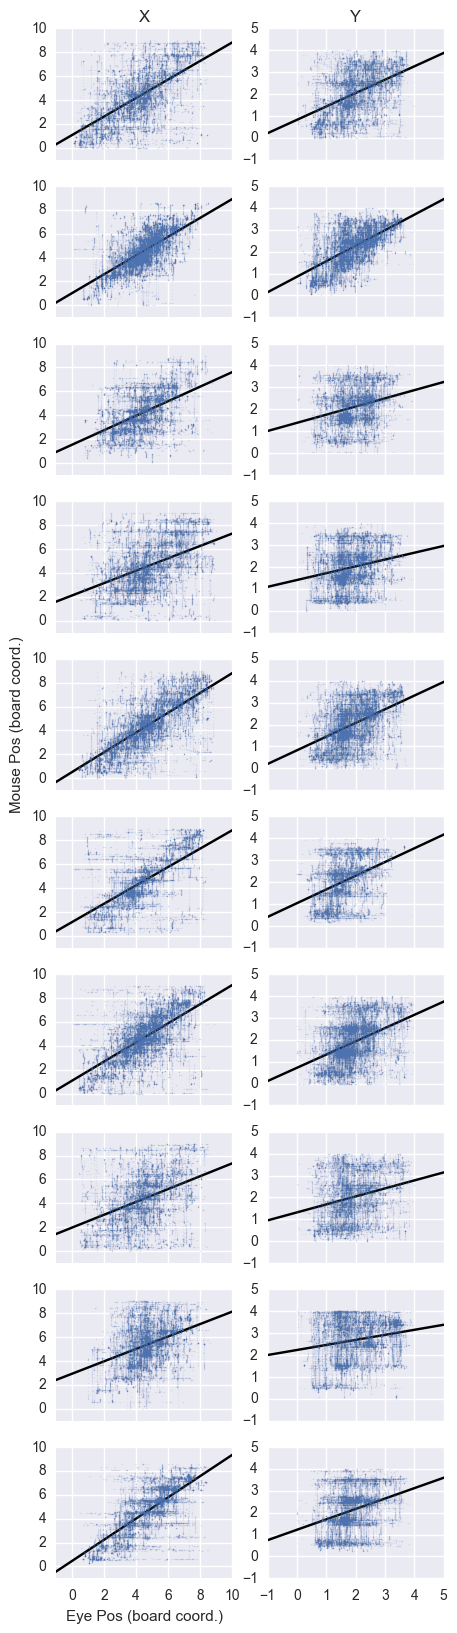

In [6]:
fig, axes = plt.subplots(len(e_list), 2, figsize=(5, 20))
for i in range(len(e_list)):
    for j, c in enumerate(['x', 'y']):
        ul = 4 if j==1 else 9
        tt = t[i].loc[pd.notnull(t[i]['eye'+c])&pd.notnull(t[i]['mou'+c])&(t[i]['task']=='playing')]
        tt = tt.loc[(tt['eye'+c]>=0)&(tt['eye'+c]<=ul)]
        tt = tt.loc[(tt['mou'+c]>=0)&(tt['mou'+c]<=ul)]
        lr = stats.linregress(tt['eye'+c], tt['mou'+c])
        print(str(i), c, lr.rvalue, lr.pvalue)
        axes[i, j].plot([-2, 11], [-2*lr.slope+lr.intercept, 11*lr.slope+lr.intercept], color='black')
        axes[i, j].plot(tt['eye'+c], tt['mou'+c], linestyle='none', marker='o', alpha=.1, markersize=1)

        
plt.setp(axes[:, 0], xlim=[-1, 10], ylim=[-1, 10])
plt.setp(axes[:, 1], xlim=[-1, 5], ylim=[-1, 5])
plt.setp(axes[:-1, :], xticklabels=[])
plt.setp(axes[-1, 0], xlabel='Eye Pos (board coord.)')
plt.setp(axes[4, 0], ylabel='Mouse Pos (board coord.)')
plt.setp(axes[0, 0], title='X')
plt.setp(axes[0, 1], title='Y')

sns.despine()

In [7]:
g_list[0].head()

,idx,id,color,gi,mi,status,bp,wp,zet,rt,mt,mx,subject,human,tstemp,is human
ts,,,,,,,,,,,,,,,,
1.429294e+12,1,1429294187763,0,1,0,eyecal,000000000000000000000000000000000000,100000000000000000000000000000000000,0,9193,None,None,AN,0,1.429294e+12,1
1.429294e+12,2,1429294187763,0,2,0,eyecal,000000000000000000000000000000000000,010000000000000000000000000000000000,1,1009,None,None,AN,0,1.429294e+12,1
1.429294e+12,3,1429294187763,0,3,0,eyecal,000000000000000000000000000000000000,001000000000000000000000000000000000,2,878,None,None,AN,0,1.429294e+12,1
1.429294e+12,4,1429294187763,0,4,0,eyecal,000000000000000000000000000000000000,000100000000000000000000000000000000,3,1160,None,None,AN,0,1.429294e+12,1
1.429294e+12,5,1429294187763,0,5,0,eyecal,000000000000000000000000000000000000,000010000000000000000000000000000000,4,919,None,None,AN,0,1.429294e+12,1


In [225]:
_t = m.loc[m['turn'].isin([117,118,119])]
_t

,x,y,subject,human,turn,turnstart,turnend,ts,xtile,ytile,tile,dur,is human


In [228]:
g.loc[g.status.isin(['playing', 'draw', 'win'])].sort_index().head(30)

,idx,id,color,gi,mi,status,bp,wp,zet,rt,mt,mx,subject,human,tstemp,is human,turn
ts,,,,,,,,,,,,,,,,,
1.429294e+12,39,1429294187763,0,0,1,playing,100000000000000000000000000000000000,000000000000000000000000000000000000,0,2909,"1429294318321,1429294318629,1429294318657,1429...","281,299;281,299;281,301;279,301;278,301;278,30...",AN,0,0.000000e+00,1,1
1.429294e+12,40,17,1,0,2,playing,100000000000000000000000000000000000,000001000000000000000000000000000000,5,0,None,None,AN,0,1.429294e+12,0,2
1.429294e+12,41,1429294187763,0,0,3,playing,100000000100000000000000000000000000,000001000000000000000000000000000000,9,7310,"1429294329368,1429294321236,1429294321238,1429...","202,231;202,231;203,231;205,231;205,232;205,23...",AN,0,0.000000e+00,1,3
1.429294e+12,42,17,1,0,4,playing,100000000100000000000000000000000000,000001000000000000000010000000000000,22,0,None,None,AN,0,1.429294e+12,0,4
1.429294e+12,43,1429294187763,0,0,5,playing,100000000100000000100000000000000000,000001000000000000000010000000000000,18,4372,"1429294341779,1429294336682,1429294336905,1429...","219,323;219,323;220,324;221,324;222,324;222,32...",AN,0,0.000000e+00,1,5
1.429294e+12,44,17,1,0,6,playing,100000000100000000100000000000000000,000011000000000000000010000000000000,4,0,None,None,AN,0,1.429294e+12,0,6
1.429294e+12,45,1429294187763,0,0,7,win,100000000100000000100000000100000000,000011000000000000000010000000000000,27,1849,"1429294347639,1429294346155,1429294346193,1429...","198,391;198,391;200,392;199,391;200,393;200,39...",AN,0,1.429294e+12,1,7
1.429294e+12,47,12,0,1,1,playing,000000000000000001000000000000000000,000000000000000000000000000000000000,17,0,None,None,AN,0,1.429294e+12,0,101
1.429294e+12,48,1429294187763,1,1,2,playing,000000000000000001000000000000000000,100000000000000000000000000000000000,0,2500,"1429294356545,1429294354409,1429294354585,1429...","520,500;520,500;520,501;521,502;522,502;525,50...",AN,0,0.000000e+00,1,102


In [194]:
gt = g.loc[g.status.isin(['playing', 'draw', 'win'])&g['is human']==1].set_index('turn')
mpvt.loc[gt.index, 'true rt'] = gt['rt']
mpvt['rt'] - mpvt['true rt']

turn
1.0          0.0
3.0          0.0
5.0          0.0
7.0          0.0
9.0          0.0
11.0         0.0
13.0         0.0
15.0         0.0
102.0        0.0
104.0        0.0
106.0        0.0
108.0        0.0
110.0        0.0
201.0     1595.0
203.0        0.0
205.0        0.0
207.0        0.0
209.0        0.0
211.0        0.0
213.0        0.0
215.0        0.0
217.0        0.0
219.0        0.0
302.0        0.0
304.0        0.0
306.0        0.0
308.0        0.0
310.0        0.0
312.0      -74.0
401.0     4064.0
           ...  
1619.0       0.0
1621.0       0.0
1702.0       0.0
1704.0       0.0
1706.0       0.0
1708.0       0.0
1710.0       0.0
1712.0       0.0
1714.0       0.0
1716.0       0.0
1718.0       0.0
1720.0       0.0
1722.0       0.0
1724.0    -214.0
1801.0    3428.0
1803.0       0.0
1805.0       0.0
1807.0       0.0
1809.0       0.0
1811.0       0.0
1813.0       0.0
1815.0       0.0
1817.0       0.0
1902.0       0.0
1904.0       0.0
1906.0       0.0
1908.0       0.0
1910.0   

In [156]:
g = g_list[0]
g = g.loc[g['status']=='playing']
m = m_list[0]

probe = g.loc[(g['gi']==1)&(g['mi']==2), :]

endtime = probe.index.values[0]
starttime = endtime - probe['rt'].values[0]
print(endtime, starttime)
mp = m.loc[(m.index>=starttime)&(m.index<=endtime), ['x', 'y']].astype(float)
mp['tstemp'] = mp.index
mp['dur'] = -mp['tstemp'].diff(periods=-1)
mp['dur'].sum()

1.42929435904e+12 1.42929435654e+12


2500.0

In [157]:
# mt = np.array([str(starttime)] + probe['mt'].values[0].split(',') + [str(endtime)]).astype(float)
mt = np.array(probe['mt'].values[0].split(',')).astype(float)
mt = mt[mt >= starttime]
(mt[1:] - mt[:-1]).sum()

2500.0

In [73]:
probe['rt']

ts
1.429294e+12    7310
Name: rt, dtype: int64